In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sentence_transformers import SentenceTransformer

c:\Users\sghia\anaconda3\Lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [2]:
import mysql.connector
from mysql.connector import Error
import pandas as pd

# MySQL database connection function
def connect_to_database():
    try:
        # Establishing connection to the database
        connection = mysql.connector.connect(
            host='crypto-matter.c5eq66ogk1mf.eu-central-1.rds.amazonaws.com',
            database='Crypto',
            user='Jing',  # Replace with your actual first name
            password='Crypto12!'
        )

        if connection.is_connected():
            db_info = connection.get_server_info()
            print("Connected to MySQL database, MySQL Server version: ", db_info)
            return connection

    except Error as e:
        print("Error while connecting to MySQL", e)
        return None

# Function to query merged data from crypto_lending_borrowing and crypto_price tables
def query_merged_crypto_data(connection):
    query = """
    SELECT clb.lending_rate, clb.borrowing_rate, clb.utilization_rate, clb.stable_borrow_rate,
    cp.*, usb.yield
    FROM crypto_lending_borrowing clb
    JOIN crypto_price cp 
        ON clb.crypto_symbol = cp.crypto_symbol
        AND clb.date = cp.date
    LEFT JOIN US_Bond_Yield usb
        ON clb.date = usb.date
    WHERE UPPER(clb.crypto_symbol) IN ('1INCHUSDT', 'BALUSDT', 'BATUSDT', 'CRVUSDT', 'ENJUSDT', 'ENSUSDT', 'KNCUSDT', 'LINKUSDT', 'MANAUSDT', 'MKRUSDT', 'RENUSDT', 'SNXUSDT', 'UNIUSDT', 'WBTCUSDT', 'YFIUSDT', 'ZRXUSDT')
    """
    cursor = connection.cursor()

    try:
        # Execute the query
        cursor.execute(query)

        # Fetch all results
        results = cursor.fetchall()

        # Get column names from cursor description
        columns = [desc[0] for desc in cursor.description]

        # Convert results to a Pandas DataFrame
        df = pd.DataFrame(results, columns=columns)

        return df

    except Error as e:
        print(f"Error: {e}")
        return None
    finally:
        cursor.close()

# Function to close the database connection
def query_quit(connection):
    if connection.is_connected():
        connection.close()
        print("MySQL connection is closed")


connection = connect_to_database()

if connection:
    # Query merged data
    merged_df = query_merged_crypto_data(connection)

    if merged_df is not None and not merged_df.empty:
        # Display first few rows of the DataFrame
        print("\nMerged DataFrame:")
        print(merged_df.head())
    else:
        print("\nNo data found after merging.")

    # Close the connection
    query_quit(connection)

Connected to MySQL database, MySQL Server version:  8.0.39

Merged DataFrame:
  lending_rate borrowing_rate utilization_rate stable_borrow_rate  \
0   -50.000000     -50.000000       -50.000000           0.030000   
1   -50.000000     -50.000000       -50.000000           0.030000   
2   -50.000000     -50.000000         0.013598           0.030000   
3   -50.000000     -50.000000         0.014834           0.030000   
4   -50.000000     -50.000000         0.014834           0.030000   

  crypto_symbol                date  high   low close adj_close   volume  \
0       BATUSDT 2020-12-02 14:00:00  0.24  0.24  0.24      0.24  1294545   
1       BATUSDT 2020-12-02 15:00:00  0.24  0.24  0.24      0.24   936344   
2       BATUSDT 2020-12-02 16:00:00  0.24  0.24  0.24      0.24   724626   
3       BATUSDT 2020-12-02 17:00:00  0.24  0.24  0.24      0.24   710071   
4       BATUSDT 2020-12-02 18:00:00  0.25  0.24  0.24      0.24  1124485   

  market_cap coin_supply     yield  
0       None 

In [3]:
# converting US bond yield from hourly to yearly under continous compounding assumptions
merged_df['yield'] = np.exp(merged_df['yield']*365*24)-1

merged_df.head()

,lending_rate,borrowing_rate,utilization_rate,stable_borrow_rate,crypto_symbol,date,high,low,close,adj_close,volume,market_cap,coin_supply,yield
0,-50.000000,-50.000000,-50.000000,0.030000,BATUSDT,2020-12-02 14:00:00,0.24,0.24,0.24,0.24,1294545,None,None,0.008552840317602313182744400
1,-50.000000,-50.000000,-50.000000,0.030000,BATUSDT,2020-12-02 15:00:00,0.24,0.24,0.24,0.24,936344,None,None,0.008552840317602313182744400
2,-50.000000,-50.000000,0.013598,0.030000,BATUSDT,2020-12-02 16:00:00,0.24,0.24,0.24,0.24,724626,None,None,0.008552840317602313182744400
3,-50.000000,-50.000000,0.014834,0.030000,BATUSDT,2020-12-02 17:00:00,0.24,0.24,0.24,0.24,710071,None,None,0.008552840317602313182744400
4,-50.000000,-50.000000,0.014834,0.030000,BATUSDT,2020-12-02 18:00:00,0.25,0.24,0.24,0.24,1124485,None,None,0.008552840317602313182744400


In [4]:
def create_llm_embeddings(dataframe, col, n_components=10):
    model = SentenceTransformer('all-MiniLM-L6-v2')

    unique_values = dataframe[col].unique()
    
    # Get embeddings for the unique values
    embeddings = model.encode(unique_values, show_progress_bar=False)

    # Apply PCA to reduce dimensionality
    pca = PCA(n_components=n_components)
    reduced_embeddings = pca.fit_transform(embeddings)

    # Create a DataFrame to hold the reduced embeddings
    reduced_embeddings_df = pd.DataFrame(reduced_embeddings, columns=[f'{col}_embedding_{i+1}' for i in range(n_components)])

    reduced_embeddings_df[col] = unique_values

    dataframe = dataframe.merge(reduced_embeddings_df, on=col, how='left')

    return dataframe

merged_df_emb = create_llm_embeddings(merged_df, "crypto_symbol", n_components=15)

print(merged_df_emb.info())


c:\Users\sghia\anaconda3\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 487675 entries, 0 to 487674
Data columns (total 29 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   lending_rate                487675 non-null  object        
 1   borrowing_rate              487675 non-null  object        
 2   utilization_rate            487675 non-null  object        
 3   stable_borrow_rate          487675 non-null  object        
 4   crypto_symbol               487675 non-null  object        
 5   date                        487675 non-null  datetime64[ns]
 6   high                        487675 non-null  object        
 7   low                         487675 non-null  object        
 8   close                       487675 non-null  object        
 9   adj_close                   487675 non-null  object        
 10  volume                      487675 non-null  int64         
 11  market_cap                  0 non-null 

PCA Components with respective variance explained:

- 1 = 10%
- 2 = 20%
- 3 = 30%
- 4 = 40%
- 5 = 45%
- 6 = 55%
- 7 = 60%
- 8 = 65%
- 9 = 75%
- 10 = 80%
- 11 = 85%
- 13 = 90%
- 14 = 95%
- 15 = 99%

In [5]:
def create_cyclical_encodings(df, date_col):
    
    days_in_month_dict = {
    1: 31, 2: 28, 3: 31, 4: 30, 5: 31, 6: 30,
    7: 31, 8: 31, 9: 30, 10: 31, 11: 30, 12: 31}

    df["Year"] = df[date_col].dt.year
    df["Month"] = df[date_col].dt.month
    df["Day"] = df[date_col].dt.day
    df["Hour"] = df[date_col].dt.hour
    df["DayofWeek"] = df[date_col].dt.dayofweek

    # Vectorized leap year handling and days in month calculation
    leap_year_mask = (df['Year'] % 4 == 0) & ((df['Year'] % 100 != 0) | (df['Year'] % 400 == 0))
    df['days_in_month'] = df['Month'].map(days_in_month_dict)
    
    # Adjust February for leap years
    df.loc[leap_year_mask & (df['Month'] == 2), 'days_in_month'] = 29

    df["Month_Sine"] = np.sin(2* np.pi * df["Month"] / 12)
    df["Month_Cosine"] = np.cos(2* np.pi * df["Month"] / 12)
    
    df["Day_Sine"] = np.sin(2* np.pi * df["Day"] / df['days_in_month'])
    df["Day_Cosine"] = np.cos(2* np.pi * df["Day"] / df['days_in_month'])
    
    df["Hour_Sine"] = np.sin(2* np.pi * df["Hour"] / 24)
    df["Hour_Cosine"] = np.cos(2* np.pi * df["Hour"] / 24)
    
    df["DayofWeek_Sine"] = np.sin(2* np.pi * df["DayofWeek"] / 7)
    df["DayofWeek_Cosine"] = np.cos(2* np.pi * df["DayofWeek"] / 7)

    df.drop(columns=["Month", "Day", "days_in_month", "Hour", "DayofWeek", "Year"], inplace=True)

    return df

merged_df_emb = create_cyclical_encodings(merged_df_emb, "date")

merged_df_emb.head()






,lending_rate,borrowing_rate,utilization_rate,stable_borrow_rate,crypto_symbol,date,high,low,close,adj_close,...,crypto_symbol_embedding_14,crypto_symbol_embedding_15,Month_Sine,Month_Cosine,Day_Sine,Day_Cosine,Hour_Sine,Hour_Cosine,DayofWeek_Sine,DayofWeek_Cosine
0,-50.000000,-50.000000,-50.000000,0.030000,BATUSDT,2020-12-02 14:00:00,0.24,0.24,0.24,0.24,...,0.169496,0.142061,-2.449294e-16,1.0,0.394356,0.918958,-0.500000,-8.660254e-01,0.974928,-0.222521
1,-50.000000,-50.000000,-50.000000,0.030000,BATUSDT,2020-12-02 15:00:00,0.24,0.24,0.24,0.24,...,0.169496,0.142061,-2.449294e-16,1.0,0.394356,0.918958,-0.707107,-7.071068e-01,0.974928,-0.222521
2,-50.000000,-50.000000,0.013598,0.030000,BATUSDT,2020-12-02 16:00:00,0.24,0.24,0.24,0.24,...,0.169496,0.142061,-2.449294e-16,1.0,0.394356,0.918958,-0.866025,-5.000000e-01,0.974928,-0.222521
3,-50.000000,-50.000000,0.014834,0.030000,BATUSDT,2020-12-02 17:00:00,0.24,0.24,0.24,0.24,...,0.169496,0.142061,-2.449294e-16,1.0,0.394356,0.918958,-0.965926,-2.588190e-01,0.974928,-0.222521
4,-50.000000,-50.000000,0.014834,0.030000,BATUSDT,2020-12-02 18:00:00,0.25,0.24,0.24,0.24,...,0.169496,0.142061,-2.449294e-16,1.0,0.394356,0.918958,-1.000000,-1.836970e-16,0.974928,-0.222521


1285
672


<Figure size 1000x600 with 0 Axes>

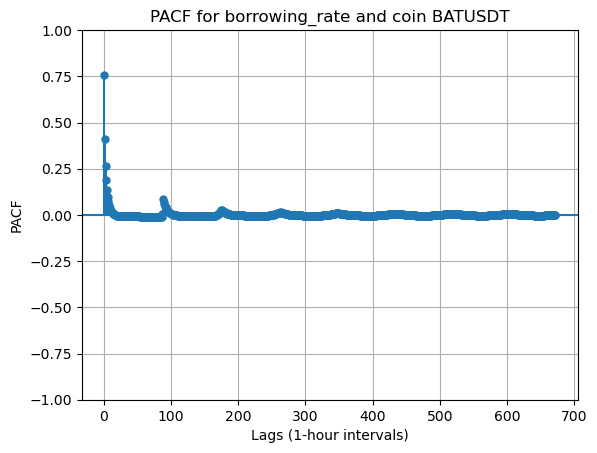

740
672


<Figure size 1000x600 with 0 Axes>

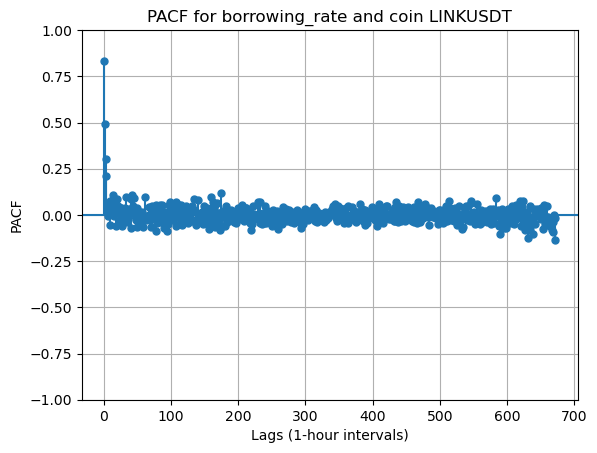

3369
672


<Figure size 1000x600 with 0 Axes>

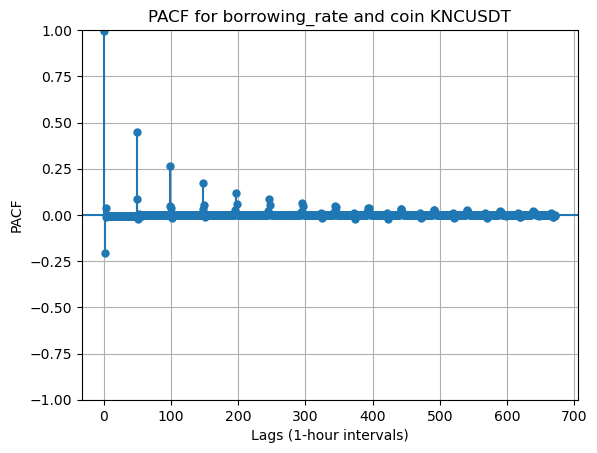

529
529


<Figure size 1000x600 with 0 Axes>

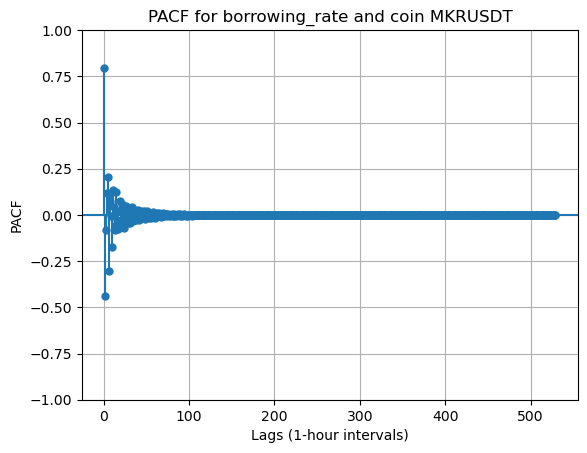

473
473


<Figure size 1000x600 with 0 Axes>

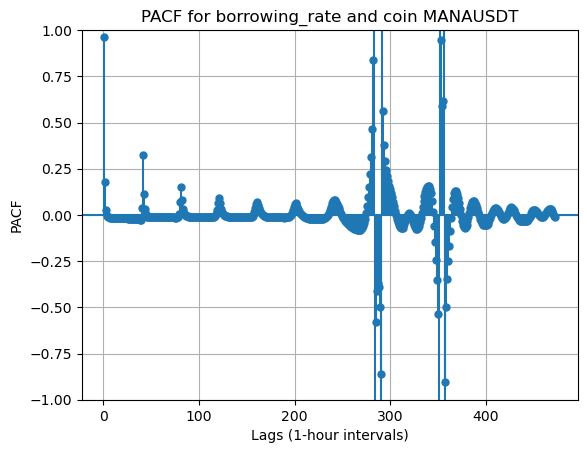

1222
672


<Figure size 1000x600 with 0 Axes>

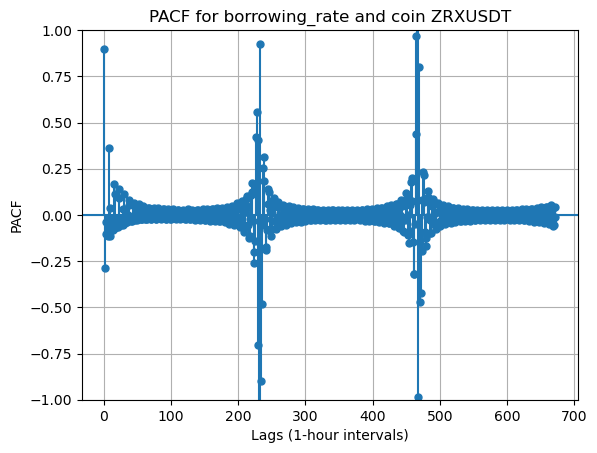

419
419


<Figure size 1000x600 with 0 Axes>

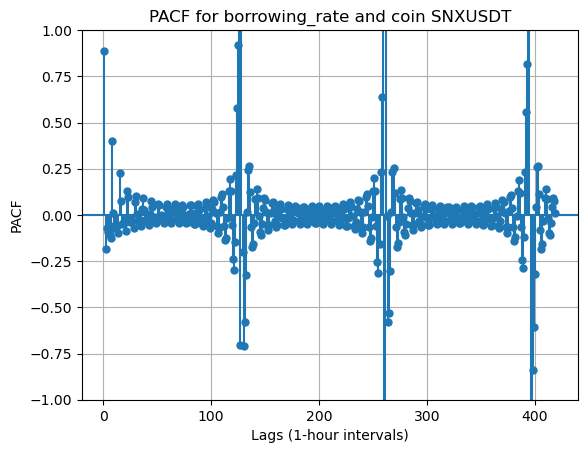

143
143


<Figure size 1000x600 with 0 Axes>

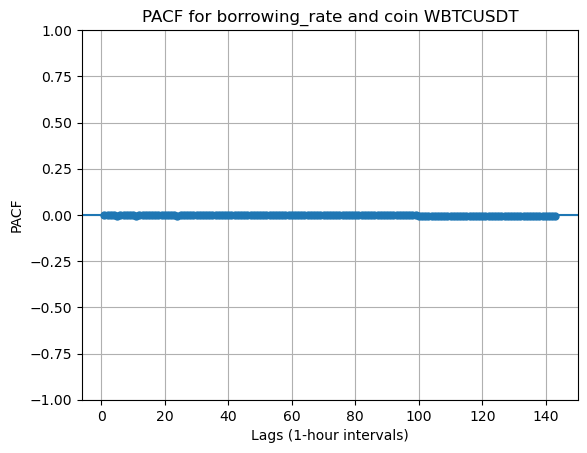

545
545


<Figure size 1000x600 with 0 Axes>

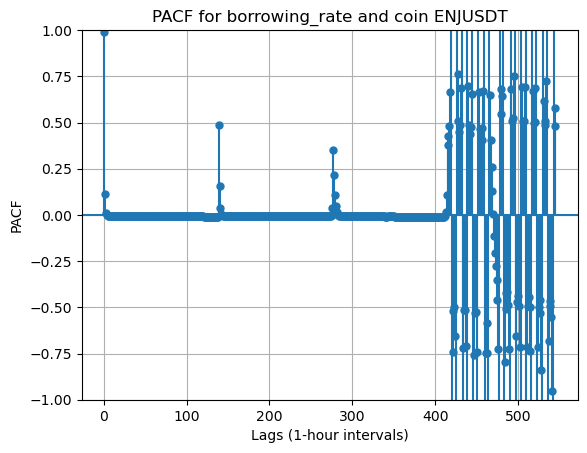

811
672


<Figure size 1000x600 with 0 Axes>

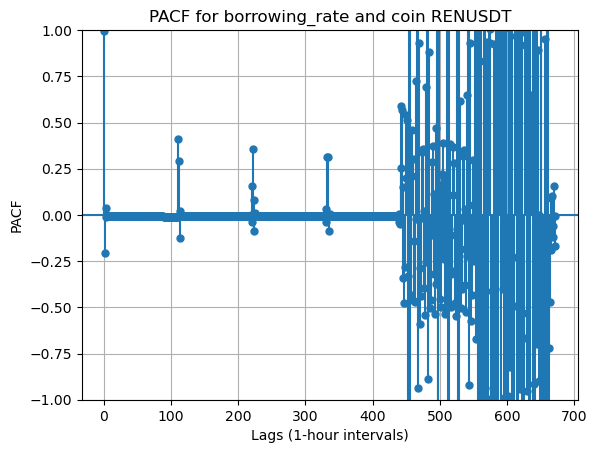

1613
672


<Figure size 1000x600 with 0 Axes>

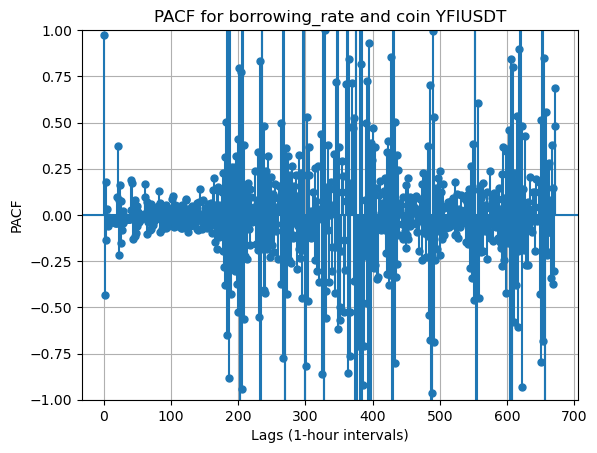

333
333


<Figure size 1000x600 with 0 Axes>

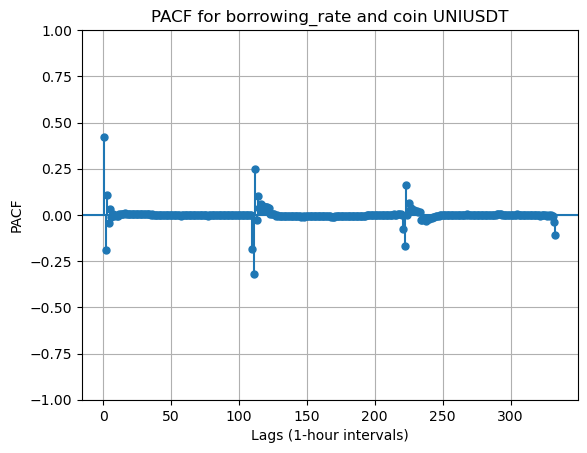

232
232


<Figure size 1000x600 with 0 Axes>

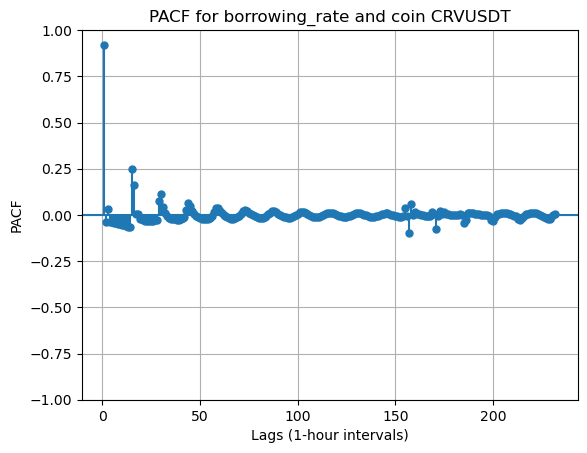

536
536


<Figure size 1000x600 with 0 Axes>

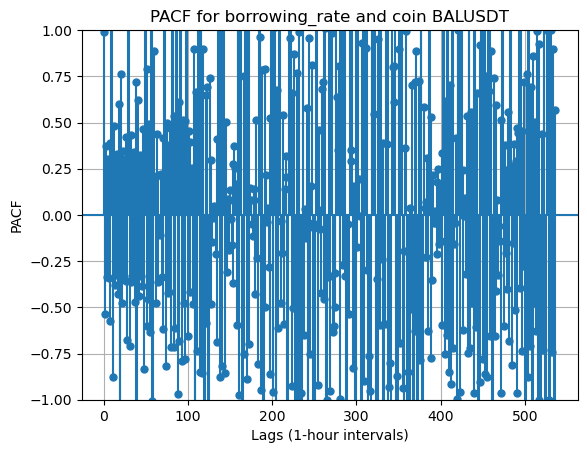

1642
672


<Figure size 1000x600 with 0 Axes>

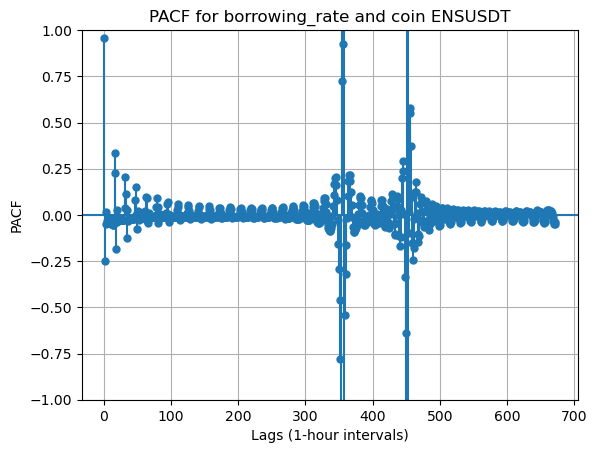

849
672


<Figure size 1000x600 with 0 Axes>

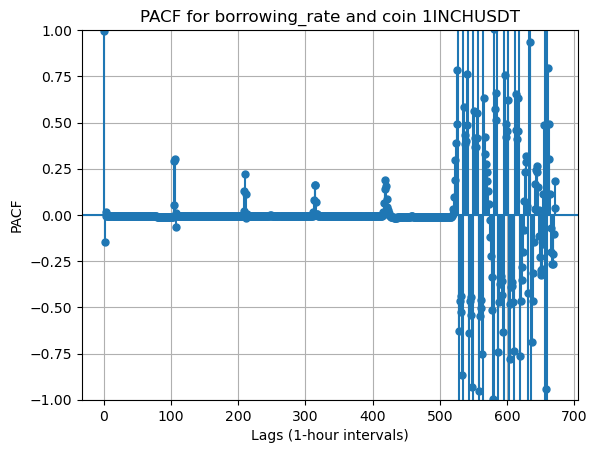

In [7]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_pacf

unique_coins = merged_df_emb["crypto_symbol"].unique()

for s in unique_coins:
    symbol_df = merged_df_emb[merged_df_emb["crypto_symbol"]==s]

    
    Ar_list = symbol_df["borrowing_rate"]

    # Step 1: Replace -50 with NaN (masking)
    Ar_list = Ar_list.replace(-50, np.nan)
    
    # Step 2: Find the longest consecutive non-NaN series
    longest_series_start = 0
    longest_series_end = 0
    longest_series_len = 0

    current_start = 0
    current_len = 0

    for i in range(len(Ar_list)):
        if pd.notna(Ar_list.iloc[i]):
            if current_len == 0:
                current_start = i
            current_len += 1
        else:
            if current_len > longest_series_len:
                longest_series_start = current_start
                longest_series_end = i
                longest_series_len = current_len
            current_len = 0

    # Check if the longest series ends at the last index
    if current_len > longest_series_len:
        longest_series_start = current_start
        longest_series_end = len(Ar_list)
        longest_series_len = current_len
    
    # Step 3: Extract the longest consecutive series
    longest_series = Ar_list.iloc[longest_series_start:longest_series_end]

    from sklearn.preprocessing import StandardScaler

    scaler = StandardScaler()

    longest_series_standard = scaler.fit_transform(longest_series.values.reshape(-1, 1)).flatten()

    minimum = len(longest_series)//2 - 1

    lags = min(minimum,672)
    
    print(minimum)
    print(lags)
    
    plt.figure(figsize=(10, 6))
    plot_pacf(longest_series_standard, lags=lags, zero=False, method='ywadjusted', alpha=None)
    plt.title(f'PACF for borrowing_rate and coin {s}')
    plt.xlabel('Lags (1-hour intervals)')
    plt.ylabel('PACF')
    plt.grid()
    plt.show()

In [6]:
merged_df_emb.drop(columns=["stable_borrow_rate", "high", "low", "adj_close", "market_cap", "coin_supply"], inplace=True)

columns = merged_df_emb.columns.to_list()

columns.remove("date")
columns.remove("crypto_symbol")

for col in columns:
    merged_df_emb[col] = merged_df_emb[col].astype('float32')

merged_df_emb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 487675 entries, 0 to 487674
Data columns (total 31 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   lending_rate                487675 non-null  float32       
 1   borrowing_rate              487675 non-null  float32       
 2   utilization_rate            487675 non-null  float32       
 3   crypto_symbol               487675 non-null  object        
 4   date                        487675 non-null  datetime64[ns]
 5   close                       487675 non-null  float32       
 6   volume                      487675 non-null  float32       
 7   yield                       487675 non-null  float32       
 8   crypto_symbol_embedding_1   487675 non-null  float32       
 9   crypto_symbol_embedding_2   487675 non-null  float32       
 10  crypto_symbol_embedding_3   487675 non-null  float32       
 11  crypto_symbol_embedding_4   487675 non-

In [7]:
merged_df_emb.sort_values(by=["date"])
merged_df_emb.head()

,lending_rate,borrowing_rate,utilization_rate,crypto_symbol,date,close,volume,yield,crypto_symbol_embedding_1,crypto_symbol_embedding_2,...,crypto_symbol_embedding_14,crypto_symbol_embedding_15,Month_Sine,Month_Cosine,Day_Sine,Day_Cosine,Hour_Sine,Hour_Cosine,DayofWeek_Sine,DayofWeek_Cosine
0,-50.0,-50.0,-50.000000,BATUSDT,2020-12-02 14:00:00,0.24,1294545.0,0.008553,-0.209401,-0.141416,...,0.169496,0.142061,-2.449294e-16,1.0,0.394356,0.918958,-0.500000,-8.660254e-01,0.974928,-0.222521
1,-50.0,-50.0,-50.000000,BATUSDT,2020-12-02 15:00:00,0.24,936344.0,0.008553,-0.209401,-0.141416,...,0.169496,0.142061,-2.449294e-16,1.0,0.394356,0.918958,-0.707107,-7.071068e-01,0.974928,-0.222521
2,-50.0,-50.0,0.013598,BATUSDT,2020-12-02 16:00:00,0.24,724626.0,0.008553,-0.209401,-0.141416,...,0.169496,0.142061,-2.449294e-16,1.0,0.394356,0.918958,-0.866025,-5.000000e-01,0.974928,-0.222521
3,-50.0,-50.0,0.014834,BATUSDT,2020-12-02 17:00:00,0.24,710071.0,0.008553,-0.209401,-0.141416,...,0.169496,0.142061,-2.449294e-16,1.0,0.394356,0.918958,-0.965926,-2.588190e-01,0.974928,-0.222521
4,-50.0,-50.0,0.014834,BATUSDT,2020-12-02 18:00:00,0.24,1124485.0,0.008553,-0.209401,-0.141416,...,0.169496,0.142061,-2.449294e-16,1.0,0.394356,0.918958,-1.000000,-1.836970e-16,0.974928,-0.222521


In [8]:
merged_df_emb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 487675 entries, 0 to 487674
Data columns (total 31 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   lending_rate                487675 non-null  float32       
 1   borrowing_rate              487675 non-null  float32       
 2   utilization_rate            487675 non-null  float32       
 3   crypto_symbol               487675 non-null  object        
 4   date                        487675 non-null  datetime64[ns]
 5   close                       487675 non-null  float32       
 6   volume                      487675 non-null  float32       
 7   yield                       487675 non-null  float32       
 8   crypto_symbol_embedding_1   487675 non-null  float32       
 9   crypto_symbol_embedding_2   487675 non-null  float32       
 10  crypto_symbol_embedding_3   487675 non-null  float32       
 11  crypto_symbol_embedding_4   487675 non-

In [9]:
columns = ["lending_rate", "borrowing_rate", "utilization_rate", "close", "volume", "yield"]

scaler = MinMaxScaler()
for col in columns:
    merged_df_emb[col] = merged_df_emb[col].replace(0, -50)
    # Create a mask for valid values
    valid_mask = merged_df_emb[col] != -50

    # Fit scaler on valid data only
    merged_df_emb.loc[valid_mask, col] = scaler.fit_transform(
        merged_df_emb.loc[valid_mask, [col]]
    ).flatten()  # Ensure it remains a 1D array

# Check the results
print(merged_df_emb.head())
    

   lending_rate  borrowing_rate  utilization_rate crypto_symbol  \
0         -50.0           -50.0        -50.000000       BATUSDT   
1         -50.0           -50.0        -50.000000       BATUSDT   
2         -50.0           -50.0          0.697102       BATUSDT   
3         -50.0           -50.0          0.697116       BATUSDT   
4         -50.0           -50.0          0.697116       BATUSDT   

                 date     close    volume     yield  \
0 2020-12-02 14:00:00  0.000002  0.002793  0.006798   
1 2020-12-02 15:00:00  0.000002  0.002020  0.006798   
2 2020-12-02 16:00:00  0.000002  0.001563  0.006798   
3 2020-12-02 17:00:00  0.000002  0.001532  0.006798   
4 2020-12-02 18:00:00  0.000002  0.002426  0.006798   

   crypto_symbol_embedding_1  crypto_symbol_embedding_2  ...  \
0                  -0.209401                  -0.141416  ...   
1                  -0.209401                  -0.141416  ...   
2                  -0.209401                  -0.141416  ...   
3         

In [10]:
def pad_window(window_df, window_length, cat_size):
    """
    Pads a window with -50 to match the shape (window_length, cat_size).
    """
    # Create an empty array filled with -50 for padding

    num_features = window_df.shape[1]
    padded_window = np.full((window_length * cat_size, num_features), -50, dtype=np.float32)
    
    # Fill in the data where available
    for idx, (index, row) in enumerate(window_df.iterrows()):
        if idx >= window_length * cat_size:
            break  # Ignore extra rows
        padded_window[idx] = row.values  # Fill rows sequentially
    
    return padded_window


def calculate_geometric_return(rate_array):
    """
    Given a 1D array of rates (lending_rate or borrowing_rate), calculates the geometric return.
    Geometric return formula: (1 + rate1) * (1 + rate2) * ... * (1 + rateN) - 1
    """
    return np.prod(1 + rate_array) - 1


# functions for creating sliding windows
def create_lagged_data(df, lag_window, pred_window, step_size, cat_size):
    # Calculate total rows
    # Ensure the date_column is datetime
    
    predicted_data = []
    lagged_data = []

    unique_coins = df["crypto_symbol"].unique()

    min_date = df['date'].min()
    max_date = df['date'].max() - pd.Timedelta(hours=pred_window)

    total_steps = int((max_date - min_date) / pd.Timedelta(hours=step_size))+1

    current_date = min_date
    window_count = 1

    cumulative_variance_lending = {coin: 0 for coin in unique_coins}

    y_pred_class = np.full((total_steps, len(unique_coins), 1), -50, dtype=np.float32)
    print(y_pred_class.shape)

    while current_date <= max_date:
        lag_end_date = current_date + pd.Timedelta(hours=lag_window)
        pred_end_date = lag_end_date + pd.Timedelta(hours=pred_window)

        lag_window_data = df[(df['date'] >= current_date) & (df['date'] < lag_end_date)]
        pred_window_data = df[(df['date'] >= lag_end_date) & (df['date'] < pred_end_date)]

        lag_window_data_corrected = lag_window_data[(lag_window_data["lending_rate"] != -50) & 
                                            (lag_window_data["borrowing_rate"] != -50)]
        pred_window_data_corrected = pred_window_data[(pred_window_data["lending_rate"] != -50) & 
                                              (pred_window_data["borrowing_rate"] != -50)]
        
        variance_lending = lag_window_data_corrected.groupby("crypto_symbol")["lending_rate"].var().reset_index()
        
        # maybe store in dataframe as well but pad the returns per rate, maybe also store initial - first return to the power of number of existing rates
        geometric_return_lending = pred_window_data_corrected.groupby("crypto_symbol")["lending_rate"].apply(calculate_geometric_return).reset_index()
        init_return_lending = pred_window_data_corrected.groupby("crypto_symbol")["lending_rate"].first().reset_index()

        for idx, coin in enumerate(unique_coins):
            if coin in variance_lending["crypto_symbol"].unique() and coin in pred_window_data_corrected["crypto_symbol"].unique():
                cumulative_variance_lending[coin] += variance_lending.loc[variance_lending["crypto_symbol"] == coin, "lending_rate"].iloc[0]

                std_lend = cumulative_variance_lending[coin]**0.5
                
                n = len(pred_window_data_corrected[pred_window_data_corrected["crypto_symbol"] == coin])

                init_return_lend_ = init_return_lending.loc[init_return_lending["crypto_symbol"] == coin, "lending_rate"].iloc[0] ** n

                geometric_return_lending_ = geometric_return_lending.loc[geometric_return_lending["crypto_symbol"] == coin, "lending_rate"].iloc[0]

                difference_lend = geometric_return_lending_ - init_return_lend_

                if difference_lend > std_lend:
                    y = 1
                elif difference_lend < std_lend * -1:
                    y = 2
                else:
                    y = 0

                y_pred_class[window_count-1, idx, 0] = y  # Store y (lending classification)
                
            else:
                cumulative_variance_lending[coin] += 0
                y_pred_class[window_count-1, idx, :] = -50  # If no data for this coin, set to -50

        lag_window_data = lag_window_data.drop(columns=["date", "crypto_symbol"])
        pred_window_data = pred_window_data.drop(columns=["date", "crypto_symbol"])

        lag_padded = pad_window(lag_window_data, lag_window, cat_size)
        pred_padded = pad_window(pred_window_data, pred_window, cat_size)

        if len(lag_window_data) > 0:
            lagged_data.append(lag_padded)
            predicted_data.append(pred_padded)

        current_date += pd.Timedelta(hours=step_size)
        window_count += 1

    X_lagged = np.array(lagged_data, dtype=np.float32)
    Y_predicted = np.array(predicted_data, dtype=np.float32)

    return X_lagged, Y_predicted, y_pred_class


X_lag , Y_pred, y_pred_class = create_lagged_data(merged_df_emb, 48, 24, 12, 16)

print(X_lag.shape)
print(Y_pred.shape)

print(y_pred_class[0,:,:])

(2803, 16, 1)
(2803, 768, 29)
(2803, 384, 29)
[[-50.]
 [-50.]
 [-50.]
 [-50.]
 [  1.]
 [  0.]
 [  0.]
 [-50.]
 [  1.]
 [-50.]
 [  0.]
 [  0.]
 [-50.]
 [-50.]
 [-50.]
 [-50.]]


 0   lending_rate                487675 non-null  float32       
 1   borrowing_rate              487675 non-null  float32       
 2   utilization_rate            487675 non-null  float32       
 3   close                       487675 non-null  float32       
 4   volume                      487675 non-null  float32       
 5   yield

In [11]:
def time_series_split(X, Y, Y_class, train_size=0.7, valid_size=0.2, test_size=0.1):
    """
    Splits time series data into train, validation, and test sets while maintaining the chronological order.
    
    :param X: Feature array of shape (samples, timesteps, features)
    :param Y: Target array of shape (samples, timesteps, features)
    :param train_size: Proportion of data to use for training (default 70%)
    :param valid_size: Proportion of data to use for validation (default 20%)
    :param test_size: Proportion of data to use for testing (default 10%)
    
    :return: Tuple of (X_train, X_valid, X_test, Y_train, Y_valid, Y_test)
    """
    total_samples = X.shape[0]
    
    # Compute the split indices
    train_end = int(total_samples * train_size)
    valid_end = int(total_samples * (train_size + valid_size))
    
    # Split the data
    X_train, X_valid, X_test = X[:train_end], X[train_end:valid_end], X[valid_end:]
    Y_train, Y_valid, Y_test = Y[:train_end], Y[train_end:valid_end], Y[valid_end:]
    Y_class_train, Y_class_valid, Y_class_test = Y_class[:train_end], Y_class[train_end:valid_end], Y_class[valid_end:]
    
    return X_train, X_valid, X_test, Y_train, Y_valid, Y_test, Y_class_train, Y_class_valid, Y_class_test

# Example usage
X_train, X_valid, X_test, Y_train, Y_valid, Y_test, Y_class_train, Y_class_valid, Y_class_test  = time_series_split(X_lag, Y_pred, y_pred_class)
print(f"Train shape: {X_train.shape}, Valid shape: {X_valid.shape}, Test shape: {X_test.shape}")

Train shape: (1962, 768, 29), Valid shape: (560, 768, 29), Test shape: (281, 768, 29)


In [12]:
print(X_train.shape)
print(X_valid.shape)
print(Y_class_train.shape)
print(Y_class_valid.shape)

(1962, 768, 29)
(560, 768, 29)
(1962, 16, 1)
(560, 16, 1)


In [13]:
Y_train = Y_train[:,:,:2]
Y_valid = Y_valid[:,:,:2]
Y_test = Y_test[:,:,:2]

In [14]:
print(Y_train[:,:,:2].shape)

(1962, 384, 2)


In [15]:
print(Y_train[0,:,0])


[-5.0000000e+01 -5.0000000e+01 -5.0000000e+01 -5.0000000e+01
 -5.0000000e+01 -5.0000000e+01 -5.0000000e+01 -5.0000000e+01
 -5.0000000e+01 -5.0000000e+01 -5.0000000e+01 -5.0000000e+01
 -5.0000000e+01 -5.0000000e+01 -5.0000000e+01 -5.0000000e+01
 -5.0000000e+01 -5.0000000e+01 -5.0000000e+01 -5.0000000e+01
 -5.0000000e+01 -5.0000000e+01 -5.0000000e+01 -5.0000000e+01
 -5.0000000e+01 -5.0000000e+01 -5.0000000e+01 -5.0000000e+01
 -5.0000000e+01 -5.0000000e+01 -5.0000000e+01 -5.0000000e+01
 -5.0000000e+01 -5.0000000e+01 -5.0000000e+01 -5.0000000e+01
 -5.0000000e+01 -5.0000000e+01 -5.0000000e+01 -5.0000000e+01
 -5.0000000e+01 -5.0000000e+01 -5.0000000e+01 -5.0000000e+01
 -5.0000000e+01 -5.0000000e+01 -5.0000000e+01 -5.0000000e+01
 -5.0000000e+01 -5.0000000e+01 -5.0000000e+01 -5.0000000e+01
 -5.0000000e+01 -5.0000000e+01 -5.0000000e+01 -5.0000000e+01
 -5.0000000e+01 -5.0000000e+01 -5.0000000e+01 -5.0000000e+01
 -5.0000000e+01 -5.0000000e+01 -5.0000000e+01 -5.0000000e+01
 -5.0000000e+01 -5.00000

In [16]:
print(X_train[2,:,0])

[-5.0000000e+01 -5.0000000e+01  1.0617519e-05  5.5099663e-06
  2.1668406e-07  2.1668406e-07  2.1668406e-07  0.0000000e+00
 -5.0000000e+01 -5.0000000e+01 -5.0000000e+01 -5.0000000e+01
 -5.0000000e+01 -5.0000000e+01 -5.0000000e+01 -5.0000000e+01
 -5.0000000e+01 -5.0000000e+01 -5.0000000e+01 -5.0000000e+01
 -5.0000000e+01 -5.0000000e+01 -5.0000000e+01 -5.0000000e+01
 -5.0000000e+01 -5.0000000e+01 -5.0000000e+01 -5.0000000e+01
 -5.0000000e+01 -5.0000000e+01 -5.0000000e+01 -5.0000000e+01
 -5.0000000e+01 -5.0000000e+01 -5.0000000e+01 -5.0000000e+01
 -5.0000000e+01 -5.0000000e+01 -5.0000000e+01 -5.0000000e+01
 -5.0000000e+01 -5.0000000e+01 -5.0000000e+01 -5.0000000e+01
 -5.0000000e+01 -5.0000000e+01 -5.0000000e+01 -5.0000000e+01
 -5.0000000e+01 -5.0000000e+01  1.4564264e-04  1.4914056e-04
  5.2313726e-06  5.2313726e-06  1.7334725e-06 -5.0000000e+01
 -5.0000000e+01 -5.0000000e+01 -5.0000000e+01 -5.0000000e+01
 -5.0000000e+01 -5.0000000e+01 -5.0000000e+01 -5.0000000e+01
 -5.0000000e+01 -5.00000

In [17]:
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Masking, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras import backend as be
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adadelta
from keras.layers import BatchNormalization
from keras.regularizers import l2

In [24]:
be.clear_session()
n_classes = 3

inputs = Input(shape=(X_train.shape[1], X_train.shape[2]))
Masking_layer = Masking(mask_value=-50)(inputs)
Lstm_layer_1 = LSTM(80,activation='tanh', return_sequences=True, stateful=False, use_cudnn=False)(Masking_layer)
Batch_norm_1 = BatchNormalization()(Lstm_layer_1)
Dropout_layer_1 = Dropout(0.3)(Batch_norm_1)
Lstm_layer_2 = LSTM(40,activation='tanh', return_sequences=False, stateful=False, use_cudnn=False)(Dropout_layer_1)  # just halved
Batch_norm_2 = BatchNormalization()(Lstm_layer_2)
Drouput_layer_2 = Dropout(0.1)(Batch_norm_2)

class_predictions = Dense(Y_class_test.shape[1]*Y_class_test.shape[2]*n_classes, activation='softmax')(Batch_norm_2)
class_predictions_reshaped = Reshape((Y_class_test.shape[1], Y_class_test.shape[2], n_classes))(class_predictions)


rate_predictions  = Dense(Y_train.shape[1]*Y_train.shape[2])(Drouput_layer_2)
rate_predictions_reshaped = Reshape((Y_train.shape[1],Y_train.shape[2]))(rate_predictions)

LSTM_base_2 = Model(inputs=inputs,outputs=[class_predictions_reshaped, rate_predictions_reshaped])

# we will keep this as a standardized learning rate optimizer across all models
optimizer = Adadelta(
    learning_rate=1.0,
    rho=0.8,
    epsilon=1e-7        # Default , to prevent division by zero
)

def masked_MSE(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    # Create a mask where y_true is not -20000
    mask = tf.not_equal(y_true, -50)
    loss = tf.square(y_true - y_pred) * tf.cast(mask, tf.float32)
    numerator = tf.reduce_sum(loss)
    denominator = tf.reduce_sum(tf.cast(mask, tf.float32))
    return numerator / denominator


def sparse_crossentropy_masked(y_true, y_pred):
    y_true = tf.cast(y_true, tf.int32)
    y_pred = tf.cast(y_pred, tf.float32)
    mask = tf.not_equal(y_true, -50)
    
    y_true_masked = tf.boolean_mask(y_true, mask)
    y_pred_masked = tf.boolean_mask(y_pred, mask)

    loss = tf.compat.v1.losses.sparse_softmax_cross_entropy(y_true_masked, y_pred_masked)
    return tf.reduce_mean(loss)

LSTM_base_2.compile(
    optimizer=optimizer,
    loss=[sparse_crossentropy_masked,masked_MSE],
    loss_weights = [0.5,0.5],
)



history = LSTM_base_2.fit(
    X_train, 
    [Y_class_train, Y_train],
    validation_data=(
        X_valid, 
        [Y_class_valid, Y_valid]
    ),
    epochs=20,
    batch_size=50,
    shuffle=False
)


Epoch 1/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 25s 484ms/step - loss: 0.5976 - reshape_1_loss: 0.0965 - reshape_loss: 1.0987 - val_loss: 0.5502 - val_reshape_1_loss: 0.0036 - val_reshape_loss: 1.0969
Epoch 2/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 20s 494ms/step - loss: 0.5761 - reshape_1_loss: 0.0569 - reshape_loss: 1.0953 - val_loss: 0.5488 - val_reshape_1_loss: 0.0034 - val_reshape_loss: 1.0944
Epoch 3/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 21s 522ms/step - loss: 0.5623 - reshape_1_loss: 0.0337 - reshape_loss: 1.0909 - val_loss: 0.5464 - val_reshape_1_loss: 0.0033 - val_reshape_loss: 1.0900
Epoch 4/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 21s 534ms/step - loss: 0.5547 - reshape_1_loss: 0.0234 - reshape_loss: 1.0860 - val_loss: 0.5434 - val_reshape_1_loss: 0.0034 - val_reshape_loss: 1.0840
Epoch 5/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 20s 509ms/step - loss: 0.5494 - reshape_1_loss: 0.0184 - reshape_loss: 1.0803 - val_loss: 0.5400 - val_reshape_1_loss: 0.0036 - val_reshape_loss: 1.0769
Epoch 6/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 20s 493

In [ ]:
be.clear_session()

n_classes = 3

inputs = Input(shape=(X_train.shape[1], X_train.shape[2]))
Masking_layer = Masking(mask_value=-50)(inputs)
Lstm_layer_1 = LSTM(80,activation='tanh', return_sequences=True, stateful=False, use_cudnn=False)(Masking_layer)
Batch_norm_1 = BatchNormalization()(Lstm_layer_1)
Dropout_layer_1 = Dropout(0.3)(Batch_norm_1)
Lstm_layer_2 = LSTM(40,activation='tanh', return_sequences=False, stateful=False, use_cudnn=False)(Dropout_layer_1)  # just halved
Batch_norm_2 = BatchNormalization()(Lstm_layer_2)
Drouput_layer_2 = Dropout(0.1)(Batch_norm_2)
predictions = Dense(Y_class_test.shape[1]*Y_class_test.shape[2]*n_classes, activation='softmax')(Batch_norm_2)
predictions_reshaped = Reshape((Y_class_test.shape[1], Y_class_test.shape[2], n_classes))(predictions)

LSTM_base = Model(inputs=inputs, outputs=predictions_reshaped)

# we will keep this as a standardized learning rate optimizer across all models
optimizer = Adadelta(
    learning_rate=1.0,
    rho=0.8,
    epsilon=1e-7        # Default , to prevent division by zero
)

def masked_MSE(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    # Create a mask where y_true is not -20000
    mask = tf.not_equal(y_true, -50)
    # Calculate the squared loss
    loss = tf.square(y_true - y_pred) * tf.cast(mask, tf.float32)
    # Masked MSE
    return tf.reduce_sum(loss) / tf.reduce_sum(tf.cast(mask, tf.float32))

def sparse_crossentropy_masked(y_true, y_pred):
    y_true = tf.cast(y_true, tf.int32)
    y_pred = tf.cast(y_pred, tf.float32)
    mask = tf.not_equal(y_true, -50)
    
    y_true_masked = tf.boolean_mask(y_true, mask)
    y_pred_masked = tf.boolean_mask(y_pred, mask)

    loss = tf.compat.v1.losses.sparse_softmax_cross_entropy(y_true_masked, y_pred_masked)
    return tf.reduce_mean(loss)

LSTM_base.compile(
    optimizer=optimizer,
    loss=sparse_crossentropy_masked,
    metrics=['accuracy']  
)
LSTM_base.summary()


c:\Users\sghia\anaconda3\Lib\site-packages\keras\src\layers\layer.py:932: UserWarning: Layer 'rev_in' (of type RevIN) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


AttributeError: Exception encountered when calling RevIN.call().

[1mCould not automatically infer the output shape / dtype of 'rev_in_2' (of type RevIN). Either the `RevIN.call()` method is incorrect, or you need to implement the `RevIN.compute_output_spec() / compute_output_shape()` method. Error encountered:

'RevIN' object has no attribute 'std'[0m

Arguments received by RevIN.call():
  • args=('<KerasTensor shape=(None, 40), dtype=float32, sparse=False, name=keras_tensor_9>',)
  • kwargs={'reverse': 'True'}

In [27]:
import os

checkpoint_filepath = os.path.join(os.getcwd(), 'LSTM_base.keras')

# Define the ModelCheckpoint callback
model_checkpoint_callback = ModelCheckpoint(
    filepath = checkpoint_filepath,
    monitor='val_loss',  # You can monitor any other metric like 'val_accuracy'
    save_best_only=True,  # Save only the best model (according to the monitored metric)
    save_weights_only=False,  # If True, only the weights will be saved, not the full model
    mode='min',  # Use 'min' for minimizing (like loss), 'max' for maximizing (like accuracy)
    verbose=1  # To print when the model is being saved
)

In [28]:
epochs = 20
batch_size = 50

history = LSTM_base.fit(x=X_train, y=Y_class_train,
                    validation_data=(X_valid, Y_class_valid),
                    epochs=epochs,
                    batch_size=batch_size,
                    shuffle=False,
                    callbacks=[model_checkpoint_callback])

Epoch 1/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step - accuracy: 0.2660 - loss: 1.0972
Epoch 1: val_loss improved from inf to 1.09758, saving model to c:\Users\sghia\OneDrive\Documents\Company_Corp_Project\Funding_rate_Aave\Saam\LSTM_base.keras
40/40 ━━━━━━━━━━━━━━━━━━━━ 25s 485ms/step - accuracy: 0.2667 - loss: 1.0971 - val_accuracy: 0.3292 - val_loss: 1.0976
Epoch 2/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step - accuracy: 0.2951 - loss: 1.0849
Epoch 2: val_loss improved from 1.09758 to 1.09147, saving model to c:\Users\sghia\OneDrive\Documents\Company_Corp_Project\Funding_rate_Aave\Saam\LSTM_base.keras
40/40 ━━━━━━━━━━━━━━━━━━━━ 19s 484ms/step - accuracy: 0.2956 - loss: 1.0848 - val_accuracy: 0.3222 - val_loss: 1.0915
Epoch 3/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step - accuracy: 0.3032 - loss: 1.0727
Epoch 3: val_loss improved from 1.09147 to 1.08215, saving model to c:\Users\sghia\OneDrive\Documents\Company_Corp_Project\Funding_rate_Aave\Saam\LSTM_base.keras
40/40 ━━━━━━━━━━━━━━━━━━

### Test results of different embedding sizes (pca components):

- 1	accuracy: 0.3267 - loss: 1.0797 - val_accuracy: 0.3584 - val_loss: 1.0815
- 8	accuracy: 0.3073 - loss: 1.0806 - val_accuracy: 0.3418 - val_loss: 1.0814
- 15	accuracy: 0.3369 - loss: 1.0822 - val_accuracy: 0.4122 - val_loss: 1.0810


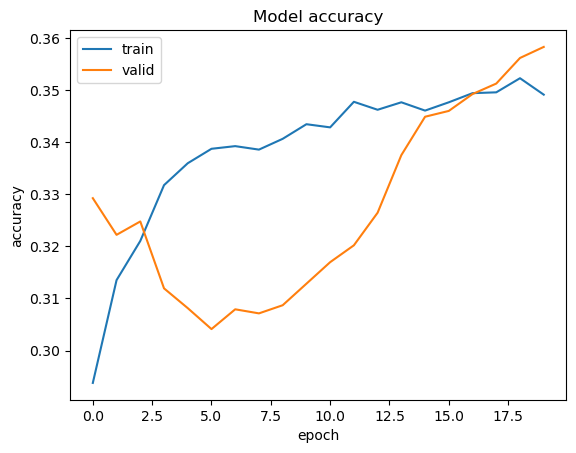

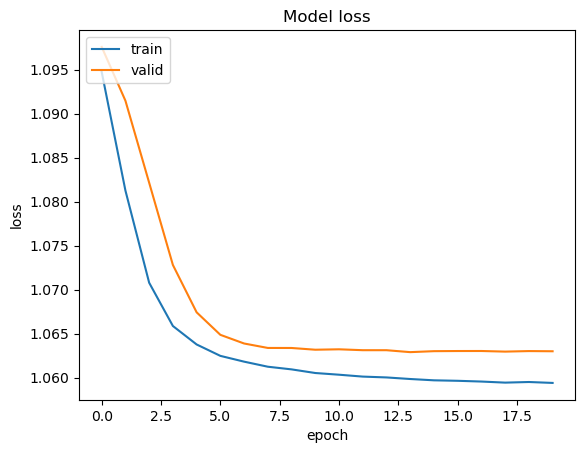

In [29]:
def display_history(history):
    """Summarize history for accuracy and loss.
    """
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.show()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.show()

display_history(history);